In [1]:
import numpy as np
import xarray as xr
from numpy import random as rn
from rasterio import transform

from lausanne_greening_scenarios.scenarios import utils as scenario_utils

In [2]:
agglom_lulc_filepath = '../data/processed/agglom-lulc.tif'
biophysical_table_filepath = '../data/processed/biophysical-table.csv'
shade_threshold = 0.75
num_scenario_runs = 10

In [3]:
sg = scenario_utils.ScenarioGenerator(agglom_lulc_filepath, biophysical_table_filepath)

In [4]:
rows = np.arange(sg.lulc_meta['height'])
cols = np.arange(sg.lulc_meta['width'])
lulc_transform = sg.lulc_meta['transform']
xs, _ = transform.xy(lulc_transform, cols, cols)
_, ys = transform.xy(lulc_transform, rows, rows)

# update the raster meta so that it can be encoded as netcdf attributes
attrs = sg.lulc_meta.copy()
attrs.update(crs=f'epsg:{attrs["crs"].to_epsg()}',
             transform=attrs['transform'].to_gdal())

In [5]:
change_props = rn.uniform(size=num_scenario_runs)

In [6]:
scenario_arr = np.array([
    sg.generate_lulc_arr(shade_threshold, change_prop) for change_prop in change_props])

In [7]:
scenario_lulc_da = xr.DataArray(scenario_arr,
                           dims=('change_prop', 'y', 'x'),
                           coords={
                               'change_prop': change_props,
                               'y': ys,
                               'x': xs
                           },
                           attrs=attrs)

In [8]:
import json
import tempfile
from os import path

import dask
import invest_ucm_calibration as iuc
import rasterio as rio
import xarray as xr

from lausanne_greening_scenarios.invest import utils as invest_utils

In [9]:
t_da_filepath = '../data/processed/tair-ucm.nc'
ref_et_da_filepath = '../data/interim/invest/ref-et.nc'
calibrated_params_filepath = '../data/interim/invest/calibrated-params.json'

In [10]:
t_da = xr.open_dataarray(t_da_filepath)
max_uhi_date = t_da.isel(time=(t_da.max(dim=['x', 'y']) - t_da.min(dim=['x', 'y'])).argmax())['time'].dt.strftime('%Y-%m-%d').item()
t_da = t_da.sel(time=max_uhi_date)
t_ref = t_da.min().item()
uhi_max = t_da.max().item() - t_ref

ref_et_da = xr.open_dataarray(ref_et_da_filepath).sel(time=max_uhi_date)
tmp_dir = tempfile.mkdtemp()
ref_et_raster_filepath = invest_utils.dump_ref_et_raster(
    ref_et_da, max_uhi_date, tmp_dir, invest_utils.get_da_rio_meta(ref_et_da))

In [11]:
with open(calibrated_params_filepath) as src:
    ucm_params = json.load(src)

In [12]:
from affine import Affine

rio_meta = scenario_lulc_da.attrs.copy()
rio_meta['transform'] = Affine.from_gdal(*rio_meta['transform'])

def _t_from_lulc(lulc_arr):
    print(lulc_arr)
    with tempfile.TemporaryDirectory() as tmp_dir:
        lulc_raster_filepath = path.join(tmp_dir, 'lulc.tif')
        with rio.open(lulc_raster_filepath, 'w', **rio_meta) as dst:
            dst.write(lulc_arr, 1)

        ucm_wrapper = iuc.UCMWrapper(lulc_raster_filepath,
                                     biophysical_table_filepath,
                                     'factors',
                                     ref_et_raster_filepath,
                                     t_ref,
                                     uhi_max,
                                     extra_ucm_args=ucm_params)
        return ucm_wrapper.predict_t_arr(0)

In [13]:
scenario_lulc_da.dims

('change_prop', 'y', 'x')

In [14]:
scenario_lulc_da.coords

Coordinates:
  * change_prop  (change_prop) float64 0.9027 0.5036 0.5467 ... 0.5447 0.7168
  * y            (y) float64 1.159e+06 1.159e+06 ... 1.149e+06 1.149e+06
  * x            (x) float64 2.525e+06 2.525e+06 ... 2.546e+06 2.546e+06

In [15]:
# we can simply iterate over `scenario_lulc_da` since 'change_prop' is its first/outermost dimension
pred_delayed = [dask.delayed(_t_from_lulc)(_scenario_lulc_da) for _scenario_lulc_da in scenario_lulc_da]
results = list(dask.compute(*pred_delayed, scheduler='processes'))

In [64]:
_pred_delayed = [dask.delayed(_t_from_lulc)(_scenario_lulc_da) for _scenario_lulc_da in scenario_lulc_da.isel(change_prop=range(3))]
arr = np.array(dask.compute(*_pred_delayed, scheduler='processes'))

In [67]:
d = dict(a='a', b='b')

In [70]:
def foo(bar):
    print(bar)

In [72]:
arr.astype('float32')

array([[[-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
        [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
        [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
        ...,
        [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
        [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
        [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         -3.4028235e+38, -3.4028235e+38, -3.4028235e+38]],

       [[-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
        [-3.4028235e+38, -3.4028235e+38, -3.4028235e+38, ...,
         -3.4028235e+38, -3.4028235e+38, -3.4028235e+38],
        [-3.4028235e+38, 

In [20]:
scenario_t_da = xr.DataArray(results, dims=scenario_lulc_da.dims, coords=scenario_lulc_da.coords, name='T')
scenario_t_da = scenario_t_da.where(scenario_t_da > 0, np.nan)

In [25]:
df = scenario_t_da.mean(dim=['x', 'y'], skipna=True).rename('T_avg').to_dataframe().reset_index()

In [26]:
df

,change_prop,T_avg
0,0.902713,21.227202
1,0.503643,21.411757
2,0.546699,21.391694
3,0.483645,21.421286
4,0.598465,21.367572
5,0.668703,21.335192
6,0.154708,21.572978
7,0.747722,21.299007
8,0.544662,21.392889
9,0.716833,21.313501


In [27]:
import seaborn as sns

<AxesSubplot:xlabel='change_prop', ylabel='T_avg'>

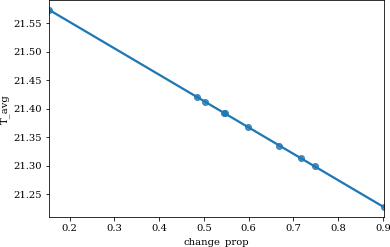

In [28]:
sns.regplot(x='change_prop', y='T_avg', data=df.dropna())

In [41]:
num_plot_cols = 4

In [57]:
plot_da = scenario_t_da.sortby('change_prop').sel(change_prop=np.linspace(0, 1, num_plot_cols + 2)[1:-1], method='nearest')

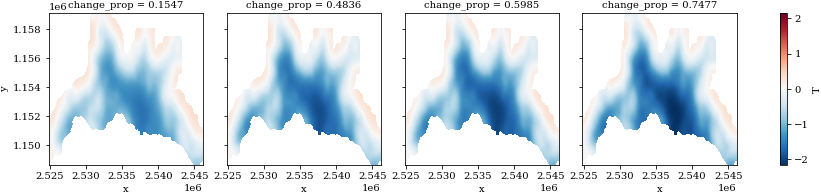

In [58]:
(plot_da - t_da).plot(col='change_prop')